In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from optimization import run_optimization
from optimization_class import Optimization

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
omega = 5e14                # angular frequency (2pi)
dl = 1e-1                   # grid size (m)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [3]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [4]:
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 1
(Hx,Hy,Ez) = simulation.solve_fields(b)

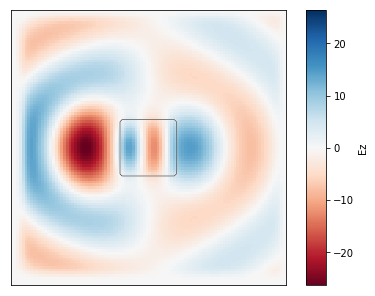

In [5]:
# plot linear field
simulation.plt_re(outline=True, cbar=True);

In [6]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[50, 80] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

## Purely Linear

In [7]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region

In [8]:
# initialize an optimization object with the optimization-specific parameters
opt_linear = Optimization(Nsteps=Nsteps, J=J, dJdE=dJdE, eps_max=eps_max, step_size=0.1, solver='born', field_start='linear')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_linear.run(simulation, b, regions=regions)

100% (100 of 100) |######################| Elapsed Time: 0:00:14 ETA:  00:00:00

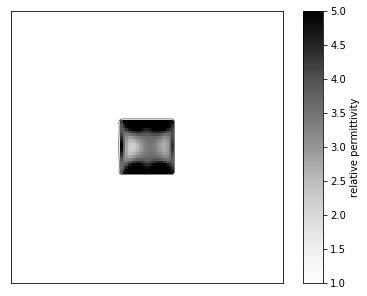

In [9]:
simulation.plt_eps()
plt.show()

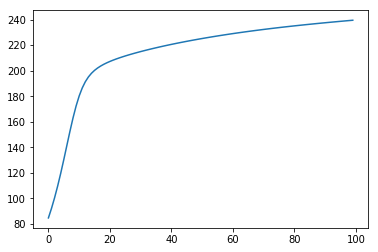

In [10]:
plt.plot(obj_fns)
plt.show()

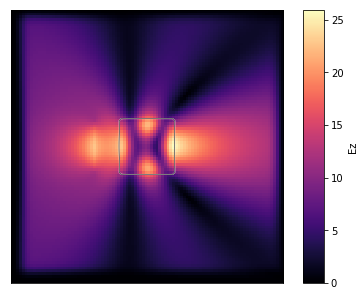

In [11]:
(Hx,Hy,Ez) = simulation.solve_fields(b)
simulation.plt_abs()
plt.show()

In [12]:
# Reset simulation
simulation.reset_eps(eps_r)

## Purely Nonlinear Optimization

In [13]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [14]:
# initialize an optimization object with the optimization-specific parameters
opt_nonlinear = Optimization(Nsteps=Nsteps, J=J, dJdE=dJdE, eps_max=eps_max, step_size=0.1, solver='born')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_nonlinear.run(simulation, b, regions=regions, nonlin_fns=nonlin_fns)

100% (100 of 100) |######################| Elapsed Time: 0:01:01 ETA:  00:00:00

In [15]:
# Note: takes a bit longer because the nonlinear solvers still need to solve twice to 
# know that the result is converged. Also the adjoint computation probably takes a bit longer
# Results look the same: 

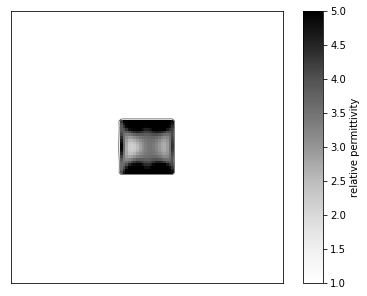

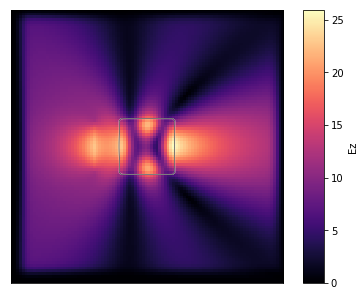

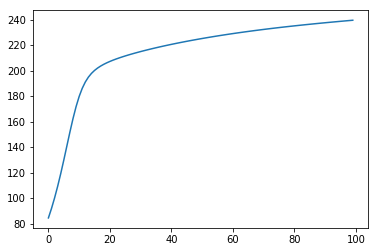

In [16]:
simulation.plt_eps()
plt.show()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(b, nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=None,solver_nl='born')
simulation.plt_abs()
plt.show()
plt.plot(obj_fns)
plt.show()

In [17]:
# Reset simulation
simulation.reset_eps(eps_r)

## Both Linear and Nonlinear

In [ ]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))
J['total']     = lambda J_lin, J_nonlin: J_lin - J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*Jregion
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin - dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [ ]:
# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=Nsteps, J=J, dJdE=dJdE, eps_max=eps_max, step_size=0.1, solver='born')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, b, regions=regions, nonlin_fns=nonlin_fns)

 24% (24 of 100) |#####                  | Elapsed Time: 0:00:21 ETA:   0:01:23

In [ ]:
# note, it doesn't really change because the objective function is hard to satisfy 
# (respectively maximize and minimize linear and nonlinear intensity at point) 
# (the nonlinearity not high enough)
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

In [ ]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields(b)
simulation.plt_abs()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(b, nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=None,solver_nl='born')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez) - np.abs(Ez_nl)
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()


one can see from the last plot that the linear field is more intense at the measuring point, but only by a little bit.

## Nonlinear with larger input power

In [ ]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*Jregion)))

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['nonlinear'] = lambda e: np.conj(e)*Jregion

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

In [ ]:
# Reset simulation and increase input power
b_new = 20*b
simulation.reset_eps(eps_r)

# note: already have a nonlinear optimization going so no need to recreate that

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_nonlinear.run(simulation, b_new, regions=regions, nonlin_fns=nonlin_fns)

In [ ]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(b_new, nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=None,solver_nl='born')

simulation.plt_abs()